In [ ]:
#Colab support
!wget https://raw.githubusercontent.com/orel509/AttacksonImplementationsCourseBook/master/Labs/WS2.mat
!wget https://raw.githubusercontent.com/orel509/AttacksonImplementationsCourseBook/master/Labs/hamming_weight.py
!wget https://raw.githubusercontent.com/orel509/AttacksonImplementationsCourseBook/master/Labs/aes_scripts/aes_lib.py

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sp
from hamming_weight import hamming_weight
from bokeh.models import Range1d
from aes_scripts.aes_crypt_8bit_and_leak import aes_crypt_8bit_and_leak, aes_sbox
#from aes_lib import aes_crypt_8bit_and_leak, aes_sbox

!pip install -U -q bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

#  Differential power analysis and correlation power analysis
DPA = 0
CPA = 1
dpa_or_cpa = CPA  # DPA

You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


Loading BokehJS ...

In [3]:
#  Make sure the matlab AES scripts are in the path
#  Load WS2, show a few traces
ws2 = sp.loadmat('WS2.mat')
print(np.shape(ws2['traces']))  # D = 200, T = 100000

(200, 100000)


In [4]:
#  shrink it a little so it runs faster
traces = ws2['traces'][:, 0:30000]
input_count = np.shape(traces)[0]
trace_length = np.shape(traces)[1]

In [47]:
p = figure(title='TODO', x_axis_label='TODO', y_axis_label='TODO', tooltips=[("x", "$x"), ("y", "$y")])
times = np.linspace(0,len(traces[0, :]), len(traces[0, :]))
p.x_range=Range1d(300, 500)
p.line(times, traces[0, :], legend_label='TODO', line_color='orange')
p.line(times, traces[1, :], legend_label='TODO2', line_color='blue')
show(p)

In [6]:
#  We want to guess byte 1 in the key
key_byte_to_guess = 12
classification_output = np.zeros(shape=(2**8, trace_length))
print(np.shape(classification_output))
# #
#  For each key guess
trace_classification = np.zeros(shape=(2**8, input_count))
inputs = ws2['inputs']

(256, 30000)


In [7]:
# guessing the byte of the key and finding the correct guess
for key_guess in range(2**8):
  # For each plaintext input
  for input in range(input_count):
    # Calculate what the value of S[P ^ K] is
    p_xor_k = np.bitwise_xor(inputs[input, key_byte_to_guess - 1], key_guess)
    s_p_xor_k = aes_sbox(p_xor_k, 1)

    if dpa_or_cpa == DPA:
      trace_classification[key_guess, input] = (np.bitwise_and(s_p_xor_k, 1) != 0)
    else:
      trace_classification[key_guess, input] = hamming_weight(s_p_xor_k)

  # % Calculate the mean of each classified set
  if dpa_or_cpa == DPA:
    mean_for_1 = np.mean(traces[trace_classification[key_guess, :] == 1, :])
    mean_for_0 = np.mean(traces[trace_classification[key_guess, :] == 0, :])
    # % Save the difference of means in the table
    classification_output[key_guess, :] = mean_for_1 - mean_for_0
  else:
    shape = np.shape(trace_classification[key_guess, :])
    my_trace = np.reshape(trace_classification[key_guess, :], newshape=(shape[0], 1))

    traces1 = (traces - traces.mean(axis=0))/traces.std(axis=0)  # A matrix
    my_trace = (my_trace - my_trace.mean(axis=0))/my_trace.std(axis=0)  # B matrix
    correlation = (np.dot(my_trace.T, traces1) / my_trace.shape[0])[0]

    classification_output[key_guess, :] = np.transpose(correlation)

  print('[{:02x}]'.format(key_guess), end=" ")
  if (key_guess % 16) == 15:
    print('\n')

[00] [01][02] [03][04] [05][06] [07][08] [09][0a] [0b][0c] [0d][0e] [0f] 

[10] [11] [12][13] [14][15] [16][17] [18][19] [1a][1b] [1c][1d] [1e][1f] 

[20][21] [22][23] [24][25] [26][27] [28][29] [2a][2b] [2c][2d] [2e][2f] 

[30][31] [32][33] [34][35] [36][37] [38][39] [3a][3b] [3c][3d][3e][3f] 

[40] [41] [42][43] [44][45] [46][47] [48][49] [4a][4b] [4c][4d] [4e][4f] 

[50][51][52][53][54] [55][56] [57][58] [59][5a] [5b] [5c][5d] [5e][5f] 

[60][61] [62][63] [64][65] [66][67] [68][69] [6a][6b] [6c][6d] [6e][6f] 

[70] [71][72] [73][74] [75][76] [77][78] [79][7a] [7b][7c] [7d] [7e][7f] 

[80][81] [82] [83][84] [85][86] [87][88] [89][8a] [8b][8c] [8d][8e] [8f] 

[90] [91][92] [93][94] [95][96] [97][98] [99][9a] [9b][9c] [9d][9e] [9f] 

[a0] [a1][a2][a3] [a4] [a5][a6] [a7][a8] [a9][aa] [ab] [ac][ad] [ae][af] 

[b0][b1] [b2] [b3][b4] [b5][b6] [b7][b8] [b9][ba] [bb][bc] [bd][be] [bf] 

[c0] [c1][c2] [c3][c4] [c5][c6] [c7][c8] [c9][ca] [cb][cc] [cd][ce] [cf] 

[d0] [d1][d2] [d3][d4] [d5][d6]

[[4. 3. 3. ... 4. 5. 3.]
 [4. 2. 3. ... 7. 5. 2.]
 [6. 3. 5. ... 3. 5. 4.]
 ...
 [3. 4. 6. ... 6. 5. 2.]
 [5. 1. 3. ... 6. 2. 4.]
 [4. 5. 4. ... 5. 4. 3.]]


<Figure size 432x288 with 0 Axes>

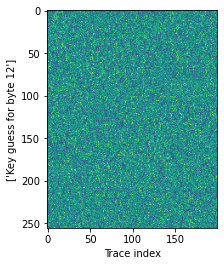

<Figure size 432x288 with 0 Axes>

In [41]:
#  Plot the trace classification matrix
plt.imshow(trace_classification)
# #imagesc(trace_classification)
plt.xlabel('Trace index')
plt.ylabel(['Key guess for byte ' + str(key_byte_to_guess)])
plt.figure()

In [9]:
#  Find out the correct timne and correct key
absolute = np.abs(classification_output)
index = np.unravel_index(np.argmax(absolute, axis=None), absolute.shape)
correct_time = index[1]

absolute = np.abs(classification_output[:, correct_time])
correct_key = np.argmax(absolute)  # this is actually correct_key + 1

In [54]:
heights = np.abs(classification_output[:, correct_time])
p = figure(title='TODO', x_axis_label='Key guess', y_axis_label='TODO', tooltips=[("x", "$x"), ("y", "$y")])
p.vbar(x=range(1, np.shape(classification_output)[0] + 1), top=heights, width=0.8,legend_label='TODO', fill_color='blue')
show(p)

In [49]:
# #
#  CPA only: show the actual power consumption at correct time, compared to
#  power model
plot1 = np.true_divide(traces[:, correct_time], 5)
p = figure(title='TODO', x_axis_label='TODO', y_axis_label='TODO', tooltips=[("x", "$x"), ("y", "$y")])
times = np.linspace(0,200,200)
p.line(times, plot1, legend_label='Power model for correct key', line_color='blue')
p.line(times, np.transpose(trace_classification[correct_key, :]), legend_label='Power consumption at correct time', line_color='orange')
show(p)

<Figure size 432x288 with 0 Axes>

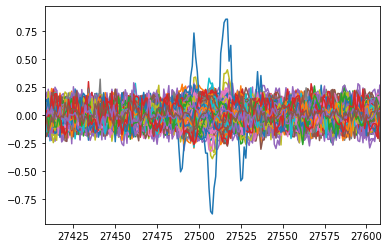

<Figure size 432x288 with 0 Axes>

In [40]:
#  plot the correct key at the correct time
ys = np.transpose(classification_output)
plt.plot(np.transpose(classification_output))
plt.xlim([correct_time - 100, correct_time + 100])
plt.figure()
#TODO
#p = figure(title='TODO', x_axis_label='TODO', y_axis_label='TODO')
#times = np.linspace(0,30000, len(ys))
#p.multi_line(xs=times*len(ys[0]), ys=ys, legend_label='TODO', line_color='blue')
#show(p)

In [48]:
p = figure(title='TODO', x_axis_label='TODO', y_axis_label='TODO', tooltips=[("x", "$x"), ("y", "$y")])
times = np.linspace(0,30000,len(classification_output[correct_key, :]))
p.line(times, classification_output[correct_key, :], legend_label='TODO', line_color='blue')
show(p)